# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.28 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
# Main Imports
from collections import deque
from collections import namedtuple
import copy

import json

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from workspace_utils import active_session

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {states.shape[0]} agents.  Each observes a state with length: {state_size}')
print(f'The state for the first agent looks like: {states[0]}')

Number of agents: 2
Size of each action: 2
There are 2 agents.  Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [11]:
#for i in range(5):                                         # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#       dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# Plotting tool
def generate_plot(name: str, mode: str, scores: list, window: int=100, threshold: float=0.5) -> None:
    firstpass = np.where(np.array(scores) > threshold)[0]
    if np.any(firstpass):
        print(f'First pass in Episode: {firstpass[0]}')
    else:
        print(f'Agent has not passed yet :(')
    score_series = pd.Series(scores)
    score_series.to_csv(f'{name}_first_{len(scores)}_scores.csv')
    windows = score_series.rolling(window)
    smoothedscores = windows.mean()
    firstave = np.where(np.array(smoothedscores) > threshold)[0]
    if np.any(firstave):
        print(f'First full pass in Episode: {firstave[0]}')
    maxave = np.max(smoothedscores)
    maxind = smoothedscores.idxmax()
    print(f'Maximum Average Score: {maxave}')
    print(f'Maximum Episode Index: {maxind}')
    
    plt.plot(smoothedscores)
    if np.any(firstave):
        plt.axvline(x=firstave[0])
    plt.axhline(y=threshold)
    plt.title(f'{name} with {mode} Experience Replay Average Scores')
    plt.xlabel('Episode')
    plt.ylabel(f'Average Score over {window} Episodes')
    plt.savefig(f'{name}_{mode}_Averages.png')
    return

In [7]:
# function to add to JSON, modified from the Geeks for Geeks article
# https://www.geeksforgeeks.org/append-to-json-file-using-python/
def write_json(new_data: dict, filename: str='MARL_experiments.json') -> None:
    if not os.path.exists(filename):
        print('initializing JSON file')
        with open(filename,'w') as jsonFile:
            nd = {'exp_details': [new_data]}
            json.dump(nd, jsonFile)
        return
    with open(filename,'r+') as file:
        print('updating JSON file')
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside exp_details
        file_data['exp_details'].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [8]:
# Modelname
modelname = 'TD3'

# Version
v = 9

## Hyperparameters
#OU Noise
MU = 0.                 # Mean value for OU Noise
SIGMA = 0.20            # Strength of the Noise (standard deviation)
THETA = 0.15            # Tendency to return to the mean

#Prioritiezd Experience Replay 
ALPHA = 1               # Strength of prioritization (0 means uniform, 1 means maximum)
BETA = 1                # Importance Sampling exponent, 0 means no IS, 1 means full compensation
BUFFER_SIZE = int(1e5)  # Overall capacity of the buffer

#Agent 
BATCH_SIZE = 128        # minibatch size
DELAY = 2               # update Actor only every DELAY Critic updates (TD3 Only!)
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
N_UPDATES = 1           # Number of updates to make every time the agent learns
TAU = 1e-2              # for soft update of target parameters
UPDATE_EVERY = 1        # How often to do the learning
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
hypers = {'ALPHA':ALPHA, 'BETA':BETA, 'BATCH_SIZE': BATCH_SIZE, 'BUFFER_SIZE': BUFFER_SIZE, 'DELAY': DELAY, 'GAMMA': GAMMA, 'LR_ACTOR': LR_ACTOR, 'LR_CRITIC': LR_CRITIC, 
         'MU': MU, 'N_UPDATES': N_UPDATES, 'SIGMA': SIGMA, 'TAU': TAU, 'THETA': THETA, 'UPDATE_EVERY': UPDATE_EVERY, 
          'WEIGHT_DECAY': WEIGHT_DECAY}

In [10]:
#Basic, uniform experience replay buffer
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, action_size: int, buffer_size: int, batch_size: int, seed: int, device: torch.device):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        self.device = device
        
    def add(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self) -> tuple:
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self) -> int:
        """Return the current size of internal memory."""
        return len(self.memory)

Actor & Critic architecture taken from: https://github.com/DiegelD/Deep-Reinforcement-Learning-ND/blob/main/p3_collab-compet/DDPG/model.py 

In [11]:
#Hidden layer
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [12]:
#The first Actor/Policy
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int, fc1_units: int=400, fc2_units: int=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): size of the state
            action_size (int): size of the action
            seed (int): Random seed
            fc1_units (int): neurons in 1st layer
            fc2_units (int): neurons in 2nd layer   
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)         
        self.fc3 = nn.Linear(fc2_units, action_size)       
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state)) 
        x = F.relu(self.fc2(x))    
        return torch.tanh(self.fc3(x)) 

In [13]:
#Now we define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int, fcs1_units: int=256, 
                 fc2_units: int=256, fc3_units: int=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action  
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)   # Increase dimension of first hidden layer by output dimension
        self.fc3 = nn.Linear(fc2_units, fc3_units)  
        self.fc4 = nn.Linear(fc3_units, 1)          
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        
        xs = F.relu(self.fcs1(state))    
        x = torch.cat((xs, action), dim=1)           # Concatenate the action to the states right on the first hidden layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  
        return self.fc4(x)      

In [47]:
#Now we define the Critic Network -- use this for TD3 agent, following: https://github.com/sfujim/TD3/blob/master/TD3.py
class TD3_Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int, fcs1_units: int=256, 
                 fc2_units: int=256, fc3_units: int=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action  
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(TD3_Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Q1 architecture
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)   # Increase dimension of first hidden layer by output dimension
        self.fc3 = nn.Linear(fc2_units, fc3_units)  
        self.fc4 = nn.Linear(fc3_units, 2)          
        
        # Q2 architecture
        self.fcs5 = nn.Linear(state_size, fcs1_units)
        self.fc6 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc7 = nn.Linear(fc2_units, fc3_units)
        self.fc8 = nn.Linear(fc3_units, 2)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        
        self.fcs5.weight.data.uniform_(*hidden_init(self.fcs5))
        self.fc6.weight.data.uniform_(*hidden_init(self.fc6))
        self.fc7.weight.data.uniform_(*hidden_init(self.fc7))
        self.fc8.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs1 = F.relu(self.fcs1(state))    
        x1 = torch.cat((xs1, action), dim=1)           # Concatenate the action to the states right on the first hidden layer
        x1 = F.relu(self.fc2(x1))
        x1 = F.relu(self.fc3(x1))  
        
        xs2 = F.relu(self.fcs5(state))    
        x2 = torch.cat((xs2, action), dim=1)           # Concatenate the action to the states right on the first hidden layer
        x2 = F.relu(self.fc6(x2))
        x2 = F.relu(self.fc7(x2))
        
        return self.fc4(x1), self.fc8(x2)      
    
    def Q1(self, state, action):
        xs1 = F.relu(self.fcs1(state))
        x1 = torch.cat((xs1, action), dim=1)
        x1 = F.relu(self.fc2(x1))
        x1 = F.relu(self.fc3(x1))
        return self.fc4(x1)

In [15]:
# OUNoise, same as last time
class OUNoise:
    """Ornstein-Uhlenbeck process"""
    def __init__(self, size: tuple, seed: int, mu: float=0., theta: float=0.15, sigma: float=0.20):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [15]:
#Let's just use the same DDPG agent as last time...
class DDPG_Agent():
    """Agent which interacts with the environment"""
    def __init__(self, state_size: int, action_size: int, hypers: dict, random_seed: int=37, filename: str=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of distinct agents
            hypers (dict): dictionary defining all the hyperparameters
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.start_episode = 0
    
        self.hypers = hypers #Storing it here for use in save-step
        
        self.BATCH_SIZE = hypers['BATCH_SIZE']
        self.BUFFER_SIZE = hypers['BUFFER_SIZE']
        self.GAMMA = hypers['GAMMA']
        LR_ACTOR = hypers['LR_ACTOR']
        LR_CRITIC = hypers['LR_CRITIC']
        self.N_UPDATES = hypers['N_UPDATES']
        self.TAU = hypers['TAU']
        self.UPDATE_EVERY = hypers['UPDATE_EVERY']
        WEIGHT_DECAY = hypers['WEIGHT_DECAY']
        
        #Define a pair of actor networks, each with a target network & dedicated optimizer
        self.actor_primaries = [Actor(state_size, action_size, random_seed+i).to(device) for i in range(2)]
        self.actor_targets = [Actor(state_size, action_size, random_seed+i).to(device) for i in range(2)]
        self.actor_optimizers = [optim.Adam(actor.parameters(), lr=LR_ACTOR) for actor in self.actor_primaries]   
        
        #Critic network with target network & dedicated optimizer
        self.critic_primary = Critic(state_size * 2, action_size * 2, random_seed).to(device)
        self.critic_target = Critic(state_size * 2, action_size * 2, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_primary.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise((2, action_size), random_seed, hypers['MU'], hypers['THETA'], hypers['SIGMA'])

        # Replay memory --> Using uniform experience replay, might try prioritized at a later time
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed, device)
        
        # Time step: only update every UPDATE_EVERY
        self.t_step = 0
        
        if filename is not None:
            self._load_state(filename)
            
    def step(self, states, actions, rewards, next_states, dones) -> None:
        """Save experience in replay memory, and use random sample from buffer to learn."""
        #Push all the new entries into the replay buffer
        for state,action,reward,next_state,done in zip(states,actions,rewards,next_states,dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory learn N_UPDATES times
            if len(self.memory) > self.BATCH_SIZE:
                for _ in range(self.N_UPDATES):
                    #Each Actor gets it's own batch
                    experiences0 = self.memory.sample()
                    experiences1 = self.memory.sample()
                    self.learn(experiences0, experiences1)        
            
    def act(self, states, add_noise: bool=True) -> None:
        """Returns actions for given states for all agents as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actor0 = self.actor_primaries[0] 
        actor1 = self.actor_primaries[1]
        actor0.eval()
        actor1.eval()
        with torch.no_grad():
            action0 = actor0(states[0]).cpu().data.numpy()
            action1 = actor1(states[1]).cpu().data.numpy()
        actor0.train()
        actor1.train()
        actions = np.array((action0, action1)).reshape((2,2))
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences0: tuple, experiences1: tuple) -> None:
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences0 (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples of the 0 Actor
            experiences1 (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples of the 1 Actor
        """
        states0, actions0, rewards0, next_states0, dones0 = experiences0
        states1, actions1, rewards1, next_states1, dones1 = experiences1
        
        states = torch.cat((states0, states1), dim=1).float().to(device)
        actions = torch.cat((actions0, actions1), dim=1).float().to(device)
        next_states = torch.cat((next_states0, next_states1), dim=1).float().to(device)
        rewards = torch.cat((rewards0, rewards1), dim=1).float().to(device)
        dones = torch.cat((dones0, dones1), dim=1).float().to(device)
    
        actions_next0 = self.actor_targets[0](states0)
        actions_next1 = self.actor_targets[1](states1)
        actions_next = torch.cat((actions_next0, actions_next1), dim=1).float().to(device)
        
        # ---------------------------- update single critic ---------------------------- #
        # Get predicted Q values from the target models
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
        # Compute the expected Q values using the primary critic network
        Q_expected = self.critic_primary(states, actions)
        # Compute the critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the critic loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_primary.parameters(), 1) #Clip gradients for stability
        self.critic_optimizer.step()
        
        actions_pred0 = self.actor_primaries[0](states0)
        actions_pred1 = self.actor_primaries[1](states1)
        actions_pred = torch.cat((actions_pred0, actions_pred1), dim=1).float().to(device)
        # ---------------------------- update actor 0 ------------------------------ #
        # Compute & Minimize Actor 0 loss
        actor_loss0 = -self.critic_primary(states, actions_pred).mean()
        self.actor_optimizers[0].zero_grad()
        actor_loss0.backward(retain_graph=True)
        self.actor_optimizers[0].step()
        
        # ---------------------------- update actor 1 ------------------------------ #
        # Compute & Minimize Actor 1 loss
        actor_loss1 = -self.critic_primary(states, actions_pred).mean()
        self.actor_optimizers[1].zero_grad()
        actor_loss1.backward()
        self.actor_optimizers[1].step()
        
        # -------------------- soft update target networks ----------------------- #
        self.soft_update()
        
    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ * θ_primary + (1 - τ) * θ_target
        """
        #Update the first Actor's target network
        for target_param, primary_param in zip(self.actor_targets[0].parameters(), self.actor_primaries[0].parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)
            
        #Updat the second Actor's target network
        for target_param, primary_param in zip(self.actor_targets[1].parameters(), self.actor_primaries[1].parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)

        #Update the Critic's target network
        for target_param, primary_param in zip(self.critic_target.parameters(), self.critic_primary.parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)
            
    def save_state(self, version: int, episodes):
        #Save the important details to a file to resume training later
        state = {'actor0': self.actor_primaries[0].state_dict(), 
                 'actor1': self.actor_primaries[1].state_dict(),
                 'critic': self.critic_primary.state_dict(),
                 'actor_optimizer0': self.actor_optimizers[0].state_dict(),
                 'actor_optimizer1': self.actor_optimizers[1].state_dict(),
                 'critic_optimizer': self.critic_optimizer.state_dict(),
                 'episodes': self.start_episode + episodes, 
                 'version': version}
        torch.save(state, f'MADDPG_v{version}_{self.start_episode + episodes}episodes.pth.tar')
        
    def _load_state(self, filename: str):
        #Taken & modified from:
        #https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/3
        if os.path.isfile(filename):
            print(f'Loading checkpoint: {filename}')
            checkpoint = torch.load(filename)
            self.start_episode += checkpoint['episodes']
            self.actor_primaries[0].load_state_dict(checkpoint['actor0'])
            self.actor_targets[0] = copy.deepcopy(self.actor_primaries[0])
            self.actor_primaries[1].load_state_dict(checkpoint['actor1'])
            self.actor_targets[1] = copy.deepcopy(self.actor_primaries[1])
            self.critic_primary.load_state_dict(checkpoint['critic'])
            self.critic_target = copy.deepcopy(self.critic_primary)
            self.actor_optimizers[0].load_state_dict(checkpoint['actor_optimizer0'])
            self.actor_optimizers[1].load_state_dict(checkpoint['actor_optimizer1'])
            self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        else:
            print(f'{filename} is not a file!')

In [51]:
#Let's try a more powerful agent: TD3
class TD3_Agent():
    """Agent which interacts with the environment"""
    def __init__(self, state_size: int, action_size: int, hypers: dict, random_seed: int=37, filename: str=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of distinct agents
            hypers (dict): dictionary defining all the hyperparameters
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.start_episode = 0
    
        self.hypers = hypers #Storing it here for use in save-step
        
        self.BATCH_SIZE = hypers['BATCH_SIZE']
        self.BUFFER_SIZE = hypers['BUFFER_SIZE']
        self.DELAY = hypers['DELAY']
        self.GAMMA = hypers['GAMMA']
        LR_ACTOR = hypers['LR_ACTOR']
        LR_CRITIC = hypers['LR_CRITIC']
        self.N_UPDATES = hypers['N_UPDATES']
        self.TAU = hypers['TAU']
        self.UPDATE_EVERY = hypers['UPDATE_EVERY']
        WEIGHT_DECAY = hypers['WEIGHT_DECAY']
        
        #Define a pair of actor networks, each with a target network & dedicated optimizer
        self.actor_primaries = [Actor(state_size, action_size, random_seed+i).to(device) for i in range(2)]
        self.actor_targets = [Actor(state_size, action_size, random_seed+i).to(device) for i in range(2)]
        self.actor_optimizers = [optim.Adam(actor.parameters(), lr=LR_ACTOR) for actor in self.actor_primaries]   
        
        #Define Critic network with the TD3 architecture
        self.critic_primary = TD3_Critic(state_size * 2, action_size * 2, random_seed).to(device)
        self.critic_target = TD3_Critic(state_size * 2, action_size * 2, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_primary.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise((2, action_size), random_seed, hypers['MU'], hypers['THETA'], hypers['SIGMA'])

        # Replay memory --> Using uniform experience replay, might try prioritized at a later time
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed, device)
        
        # Counter for Critic updates -- Critic updates more often than Actor
        self.critic_counter = 0
        
        # Time step: only update every UPDATE_EVERY
        self.t_step = 0
        
        if filename is not None:
            self._load_state(filename)
            
    def step(self, states, actions, rewards, next_states, dones) -> None:
        """Save experience in replay memory, and use random sample from buffer to learn."""
        #Push all the new entries into the replay buffer
        for state,action,reward,next_state,done in zip(states,actions,rewards,next_states,dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory learn N_UPDATES times
            if len(self.memory) > self.BATCH_SIZE:
                for _ in range(self.N_UPDATES):
                    #Each Actor gets it's own batch
                    experiences0 = self.memory.sample()
                    experiences1 = self.memory.sample()
                    self.learn(experiences0, experiences1)        
            
    def act(self, states, add_noise: bool=True) -> None:
        """Returns actions for given states for all agents as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actor0 = self.actor_primaries[0] 
        actor1 = self.actor_primaries[1]
        actor0.eval()
        actor1.eval()
        with torch.no_grad():
            action0 = actor0(states[0]).cpu().data.numpy()
            action1 = actor1(states[1]).cpu().data.numpy()
        actor0.train()
        actor1.train()
        actions = np.array((action0, action1)).reshape((2,2))
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences0: tuple, experiences1: tuple) -> None:
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences0 (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples of the 0 Actor
            experiences1 (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples of the 1 Actor
        """
        
        states0, actions0, rewards0, next_states0, dones0 = experiences0
        states1, actions1, rewards1, next_states1, dones1 = experiences1
        
        states = torch.cat((states0, states1), dim=1).float().to(device)
        actions = torch.cat((actions0, actions1), dim=1).float().to(device)
        next_states = torch.cat((next_states0, next_states1), dim=1).float().to(device)
        rewards = torch.cat((rewards0, rewards1), dim=1).float().to(device)
        dones = torch.cat((dones0, dones1), dim=1).float().to(device)
    
        #print(f'next_states shape: {next_states.shape}')
        #print(f'rewards shape: {rewards.shape}')
        #print(f'dones shape: {dones.shape}')
    
        with torch.no_grad():
            actions_next0 = self.actor_targets[0](states0)
            actions_next1 = self.actor_targets[1](states1)
            actions_next = torch.cat((actions_next0, actions_next1), dim=1).float().to(device)
            #print(f'actions_next shape: {actions_next.shape}')
        
            # ----------------------- Get combined Critic update --------------------------- #
            # Get predicted Q values from the target models
            Q_targets_nextA, Q_targets_nextB = self.critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            #print(f'Q_targets_nextA shape: {Q_targets_nextA.shape}')
            target_Q = torch.min(Q_targets_nextA, Q_targets_nextB)
            #print(f'target_Q shape: {target_Q.shape}')
            Q_targets = rewards + (self.GAMMA * (1 - dones) * target_Q)
            #print(f'Q_targets shape: {Q_targets.shape}')
            
        
        # Compute the expected Q values using the primary critic networks
        Q_expectedA, Q_expectedB = self.critic_primary(states, actions)
        
        # Compute the critic loss
        critic_loss = F.mse_loss(Q_expectedA, Q_targets) + F.mse_loss(Q_expectedB, Q_targets)

        # Minimize the critic loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_primary.parameters(), 1) #Clip gradients for stability
        self.critic_optimizer.step()
        
        #Only update Actor every DELAY updates of the Critic.  Original paper recommends DELAY == 2
        self.critic_counter = (self.critic_counter + 1) % self.DELAY
        if self.critic_counter == 0:
            actions_pred0 = self.actor_primaries[0](states0)
            actions_pred1 = self.actor_primaries[1](states1)
            actions_pred = torch.cat((actions_pred0, actions_pred1), dim=1).float().to(device)
            # ---------------------------- update actor 0 ------------------------------ #
            # Compute & Minimize Actor 0 loss
            actor_loss0 = -self.critic_primary.Q1(states, actions_pred).mean()
            self.actor_optimizers[0].zero_grad()
            actor_loss0.backward(retain_graph=True)
            self.actor_optimizers[0].step()
        
            # ---------------------------- update actor 1 ------------------------------ #
            # Compute & Minimize Actor 1 loss
            actor_loss1 = -self.critic_primary.Q1(states, actions_pred).mean()
            self.actor_optimizers[1].zero_grad()
            actor_loss1.backward()
            self.actor_optimizers[1].step()
        
            # -------------------- soft update target networks ----------------------- #
            self.soft_update()
        
    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ * θ_primary + (1 - τ) * θ_target
        """
        #Update the first Actor's target network
        for target_param, primary_param in zip(self.actor_targets[0].parameters(), self.actor_primaries[0].parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)
            
        #Updat the second Actor's target network
        for target_param, primary_param in zip(self.actor_targets[1].parameters(), self.actor_primaries[1].parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)

        #Update the Critic's target network
        for target_param, primary_param in zip(self.critic_target.parameters(), self.critic_primary.parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)
            
    def save_state(self, version: int, episodes):
        #Save the important details to a file to resume training later
        state = {'actor0': self.actor_primaries[0].state_dict(), 
                 'actor1': self.actor_primaries[1].state_dict(),
                 'critic': self.critic_primary.state_dict(),
                 'actor_optimizer0': self.actor_optimizers[0].state_dict(),
                 'actor_optimizer1': self.actor_optimizers[1].state_dict(),
                 'critic_optimizer': self.critic_optimizer.state_dict(),
                 'episodes': self.start_episode + episodes, 
                 'version': version}
        torch.save(state, f'TD3_v{version}_{self.start_episode + episodes}episodes.pth.tar')
        
    def _load_state(self, filename: str):
        #Taken & modified from:
        #https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/3
        if os.path.isfile(filename):
            print(f'Loading checkpoint: {filename}')
            checkpoint = torch.load(filename)
            self.start_episode += checkpoint['episodes']
            self.actor_primaries[0].load_state_dict(checkpoint['actor0'])
            self.actor_targets[0] = copy.deepcopy(self.actor_primaries[0])
            self.actor_primaries[1].load_state_dict(checkpoint['actor1'])
            self.actor_targets[1] = copy.deepcopy(self.actor_primaries[1])
            self.critic_primary.load_state_dict(checkpoint['critic'])
            self.critic_target = copy.deepcopy(self.critic_primary)
            self.actor_optimizers[0].load_state_dict(checkpoint['actor_optimizer0'])
            self.actor_optimizers[1].load_state_dict(checkpoint['actor_optimizer1'])
            self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        else:
            print(f'{filename} is not a file!')

In [17]:
# Training Loop
def train(agent, modelname: str, version: int, num_episodes: int, t_step_limit: int=1000) -> list:
    
    mainscores = []
    mainscore_window = deque(maxlen=100)
    start_time = time.perf_counter()
    for i in range(num_episodes):
        ep_start = time.perf_counter()
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment    
        states = env_info.vector_observations                      # get the current state (for each agent)
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)
            
        agent.reset()                                              # Clears noise parameter
        
        for _ in range(t_step_limit):
            actions = agent.act(states)                            # Agent takes actions
            env_info = env.step(actions)[brain_name]               # send all actions to the environment
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            scores += env_info.rewards                             # update the score (for each agent) 
            
            agent.step(states,actions,rewards,next_states,dones)   # Agent takes a step, with all that entails
            
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
                
        mainscore_window.append(np.max(scores))
        mainscores.append(np.max(scores))
        ep_end = time.perf_counter()
        if i % 100 == 0:
            ept = ep_end - ep_start
            print(f'Episode: {i}, Episode Time: {ept: .3f}, Total Time: {(ep_end - start_time): .3f}')
            print(f'Average Score: {mainscores[-1]: .3f}')
        
    print(f'------------- Training Complete! ---------------')
    print(f'Maximum score: {max(mainscores): .3f}, in Episode: {mainscores.index(max(mainscores))}')
    save_path = f'{modelname}_v{version}_{agent.start_episode + num_episodes}episodes.pth.tar'
    agent.save_state(version, num_episodes)
    
    clock_time = time.perf_counter() - start_time
    nd = {'modelname': modelname , 'version': version, 'save_path': save_path, 'hypers': agent.hypers, 'clock_time': clock_time, 
          'Episodes': num_episodes, 'final_score': mainscores[-1], 'max_score': max(mainscores), 
          'average_score': np.mean(mainscores)
         }
    write_json(nd)
        
    return mainscores

In [52]:
if modelname == 'MADDPG':
    agent = DDPG_Agent(state_size, action_size, hypers)
elif modelname == 'TD3':
    agent = TD3_Agent(state_size, action_size, hypers)

In [43]:
a = torch.randn(3,4)
b = torch.randn(3,4)

c = torch.cat((a,b), dim=0)
d = torch.cat((a,b), dim=1)
print(f'c shape: {c.shape}')
print(f'd shape: {d.shape}')

c shape: torch.Size([6, 4])
d shape: torch.Size([3, 8])


Episode: 0, Episode Time:  0.025, Total Time:  0.025
Average Score:  0.000
Episode: 100, Episode Time:  0.250, Total Time:  26.445
Average Score:  0.000
Episode: 200, Episode Time:  0.263, Total Time:  53.128
Average Score:  0.000
Episode: 300, Episode Time:  0.255, Total Time:  79.782
Average Score:  0.000
Episode: 400, Episode Time:  0.270, Total Time:  106.563
Average Score:  0.000
Episode: 500, Episode Time:  0.296, Total Time:  133.465
Average Score:  0.000
Episode: 600, Episode Time:  0.270, Total Time:  160.275
Average Score:  0.000
Episode: 700, Episode Time:  0.259, Total Time:  187.160
Average Score:  0.000
Episode: 800, Episode Time:  0.263, Total Time:  214.000
Average Score:  0.000
Episode: 900, Episode Time:  0.252, Total Time:  240.814
Average Score:  0.000
Episode: 1000, Episode Time:  0.253, Total Time:  267.747
Average Score:  0.000
Episode: 1100, Episode Time:  0.264, Total Time:  294.482
Average Score:  0.000
Episode: 1200, Episode Time:  0.263, Total Time:  321.543

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


Maximum Average Score: 0.0019000000320374966
Maximum Episode Index: 99


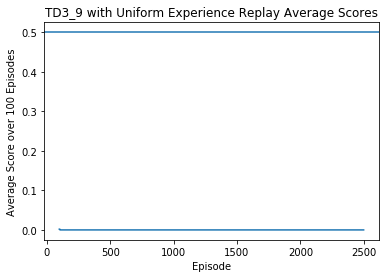

In [53]:
with active_session():
    scores = train(agent, modelname, v, 2500)
    generate_plot(f'{modelname}_{v}', 'Uniform', scores)